In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from prophet import Prophet
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
import logging
logging.getLogger("cmdstanpy").disabled = True

### Functions

In [ ]:
def calculate_aic(model, prediction):
    # Calculate residuals
    test['yhat'] = prediction['yhat'][-len(test):].values
    test['residuals'] = test['y'] - test['yhat']

    # Calculate log-likelihood
    sigma2 = np.var(test['residuals'])
    n = len(test)
    log_likelihood = -n/2 * (np.log(2 * np.pi * sigma2) + 1)

    # Estimate number of parameters (k)
    k = len(model.params)

    # Calculate AIC
    AIC = 2 * k - 2 * log_likelihood

    return AIC

### Train Models

In [ ]:
# Read in daily data
df = pd.read_parquet('data/TX_AUS.parquet')
df = df.rename(columns={'invoice_date': 'ds', 'sale_value': 'y'})
df.index.names = ['ds']
df.head()

,y
ds,
2018-01-02,36191
2018-01-03,43787
2018-01-04,48195
2018-01-05,44204
2018-01-06,31278


In [ ]:
# Aggregate by weekly mean
dt = df.copy()
dt = dt['y'].resample('W').mean()
dt = pd.DataFrame(dt)
dt.head()

,y
ds,
2018-01-07,40431.666667
2018-01-14,38851.714286
2018-01-21,36738.428571
2018-01-28,32524.857143
2018-02-04,36487.714286


In [ ]:
# Split the data into training and testing sets
train, test = df[:'2020-11-25'], df['2020-11-25':]

# Create the ARIMA model With daily data
daily_arima = ARIMA(train, order=(2,1,1))
daily_arima = daily_arima.fit()

# Get the forecast for test data
daily_forecast = daily_arima.get_forecast(steps = len(test))
daily_forecast_conf = daily_forecast.conf_int()

# Split the data into training and testing sets
train, test = dt[:'2020-11-25'], dt['2020-11-25':]

# Create the ARIMA model with weekly data
weekly_arima = ARIMA(train, order=(0,1,1))
weekly_arima = weekly_arima.fit()

# Get the forecast for test data
weekly_forecast = weekly_arima.get_forecast(steps = len(test))
weekly_forecast_conf = weekly_forecast.conf_int()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# Create the DataFrame
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},  # Corrected here
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])

# Convert to datetime
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])

# Calculate the upper window
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

# Display the updated DataFrame
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


In [ ]:
# Split the data into training and testing sets
train, test = df[:'2020-11-25'], df['2020-11-25':]
train = train.reset_index()
test = test.reset_index()

# Create prophet model
model_daily = Prophet(daily_seasonality=False, holidays=lockdowns)
model_daily = model_daily.fit(train)
future = model_daily.make_future_dataframe(periods=len(test))
prediction_daily = model_daily.predict(future)

# Split the data into training and testing sets
train, test = dt[:'2020-11-25'], dt['2020-11-25':]
train = train.reset_index()
test = test.reset_index()

# Create Prophet model
model_weekly = Prophet(daily_seasonality=False, holidays=lockdowns)
model_weekly = model_weekly.fit(train)
future = model_weekly.make_future_dataframe(periods=len(test) + 2)
prediction_weekly = model_weekly.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


### Comparison

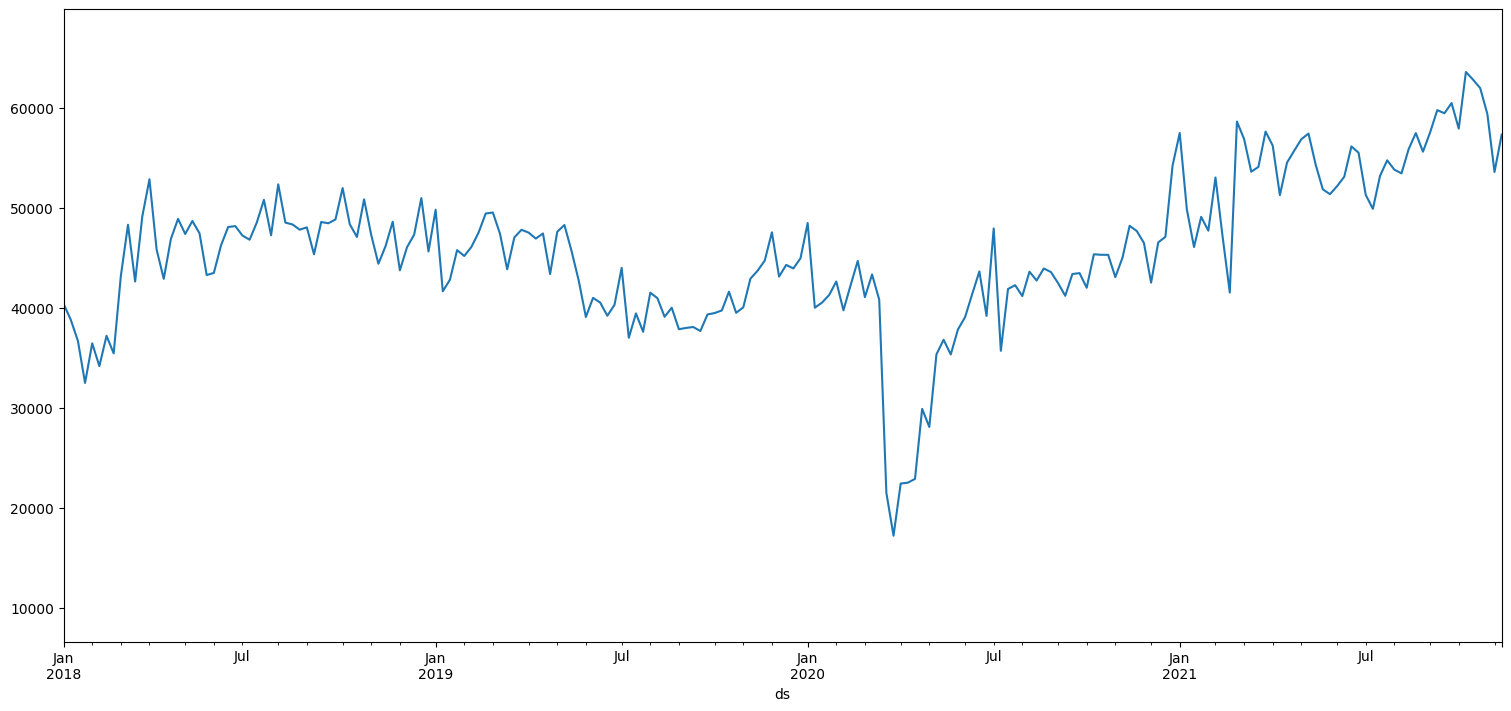

In [ ]:
# Plot observed values
fig, ax = plt.subplots(figsize=(15, 7), layout='constrained')
ax = dt['y'].plot()

# Plot forecasted values
plt.plot(prediction_daily['ds'], prediction_daily['yhat'], label='Daily Forecast', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(prediction_weekly.index,
                prediction_weekly['yhat_lower'],
                prediction_weekly['yhat_upper'], color='g', alpha=0.1)

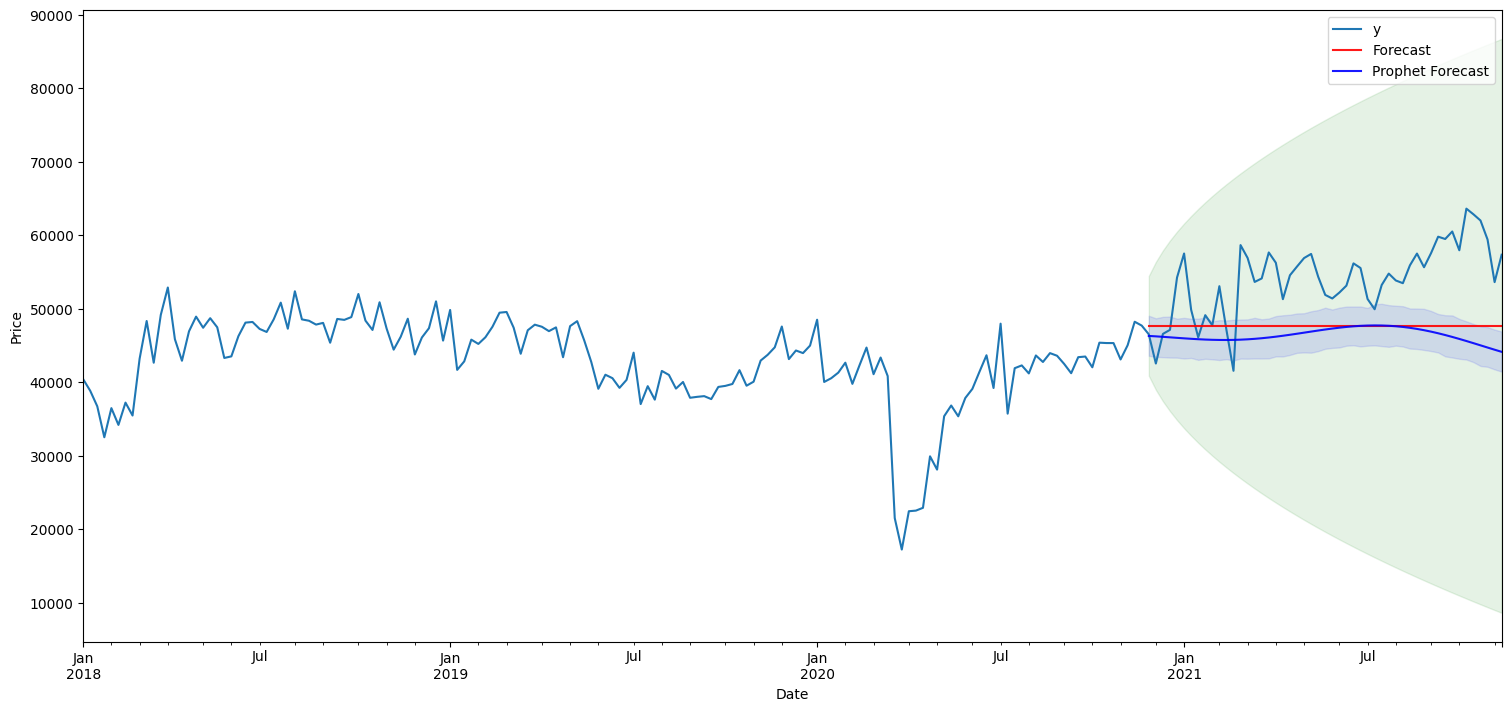

In [ ]:
# Plot observed values
fig, ax = plt.subplots(figsize=(15, 7), layout='constrained')
ax = dt['y'].plot()

# Plot forecasted values
weekly_forecast.predicted_mean.plot(ax=ax, label='Forecast', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(weekly_forecast_conf.index,
                weekly_forecast_conf.iloc[:, 0],
                weekly_forecast_conf.iloc[:, 1], color='g', alpha=0.1)

# Plot prophet forecasted values
prediction_weekly = prediction_weekly.set_index('ds')['2020-11-25':]
prediction_weekly.index = dt['2020-11-25':].index
prediction_weekly['yhat'].plot(ax=ax, label='Prophet Forecast', color='blue', alpha=0.9)

# Plot prophet confidence interval
ax.fill_between(prediction_weekly.index,
                prediction_weekly['yhat_lower'],
                prediction_weekly['yhat_upper'], color='b', alpha=0.1)


# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()